# import module

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data to dataframe

In [2]:
policy_path = '../dataset/policy_0702.csv'
claim_path = '../dataset/claim_0702.csv'
trainingset_path = '../dataset/training-set.csv'
testingset_path = '../dataset/testing-set.csv'

In [3]:
policy_df = pd.read_csv(policy_path, encoding='utf-8')
claim_df = pd.read_csv(claim_path, encoding='utf-8')
trainingset_df = pd.read_csv(trainingset_path, encoding='utf-8')
testingset_df = pd.read_csv(testingset_path, encoding='utf-8')

In [4]:
print('policy_df has: ' + str(policy_df.shape[0]) + ' datas, and ' + str(policy_df.shape[1]) + ' infomations')
print('training set has: ' + str(trainingset_df.shape[0]))
print('testing set has: ' + str(testingset_df.shape[0]))

policy_df has: 1747942 datas, and 41 infomations
training set has: 210763
testing set has: 140510


# feature engineering

In [5]:
#calculate the quantity of insurance per Policy_Number
policy_df['Insura_Counts'] = policy_df['Policy_Number'].map(policy_df['Policy_Number'].value_counts())
#encoding
policy_df['Cancellation'] = policy_df['Cancellation'].apply({'Y':1, ' ':0}.get)
policy_df['Main_Insurance_Coverage_Group'] = policy_df['Main_Insurance_Coverage_Group'].apply({'車責':'car_duty', '竊盜':'car_steal', '車損':'car_damage'}.get)
#calculate the age of owner
policy_df['iage']=policy_df['ibirth'].str.extract('(19..)', expand=True)
policy_df['iage'].fillna(value=2017, inplace=True)#取眾數
policy_df['iage'] = policy_df['iage'].apply(lambda x: 2017-int(x))
policy_df['dage']=policy_df['dbirth'].str.extract('(19..)', expand=True)
policy_df['dage'].fillna(value=2017, inplace=True)#取眾數
policy_df['dage'] = policy_df['dage'].apply(lambda x: 2017-int(x))

In [6]:
#clean Coverage_Deductible_if_applied(自負額)
ignore_Deductible = ['09I', '10A', '14E', '15F', '15O', '20B', '20K', '29K', '32N', '33F', '33O', '56K', '65K']#與自負額無關,請忽略
special_Deductible = ['00I', '02K', '04M', '37J', '66C', '66L']#1;2;3;8000... (1表示3000/5000/7000;  2表示5000/8000;  3表示5000/8000/10000;  6表示15000; 7表示20000; 8:依條款約定; 其他金額表示每次自負額)
percent_Deductible = ['05N', '14N', '68E']#0;10;20自負額比例 ( 0: 無自負額; 10:10%;  20:20%)

In [7]:
policy_df['Insurance_Coverage'] = policy_df['Insurance_Coverage'].apply({'00I':'special_Deductible', '02K':'special_Deductible', '04M':'special_Deductible',
                                                                         '37J':'special_Deductible', '66C':'special_Deductible', '66L':'special_Deductible', 
                                                                         '05N':'percent_Deductible', '14N':'percent_Deductible','68E':'percent_Deductible'}.get)
policy_df['Insurance_Coverage'].fillna(value='ignore_Deductible', inplace=True)

In [8]:
policy_df['Insurance_Coverage'].unique()

array(['ignore_Deductible', 'percent_Deductible', 'special_Deductible'],
      dtype=object)

In [9]:
policy_df['Coverage_Deductible_if_applied'] = np.absolute(policy_df['Coverage_Deductible_if_applied'].values)
# policy_df.loc[policy_df[policy_df['Insurance_Coverage']=='ignore_Deductible'].index, 'Coverage_Deductible_if_applied'] = 0

In [10]:
policy_df.loc[policy_df[(policy_df['Insurance_Coverage']=='special_Deductible') & (policy_df['Coverage_Deductible_if_applied'] == 1)].index,
              'Coverage_Deductible_if_applied'] = 5000
policy_df.loc[policy_df[(policy_df['Insurance_Coverage']=='special_Deductible') & (policy_df['Coverage_Deductible_if_applied'] == 2)].index,
              'Coverage_Deductible_if_applied'] = 6500
policy_df.loc[policy_df[(policy_df['Insurance_Coverage']=='special_Deductible') & (policy_df['Coverage_Deductible_if_applied'] == 3)].index,
              'Coverage_Deductible_if_applied'] = 8000

In [11]:
policy_df.loc[policy_df[(policy_df['Insurance_Coverage']=='ignore_Deductible') & (policy_df['Coverage_Deductible_if_applied'] < 1000)].index, 'Coverage_Deductible_if_applied'] = 0

In [12]:
policy_df['Coverage_Deductible_if_applied_percent'] = policy_df['Coverage_Deductible_if_applied'].copy()
policy_df.loc[policy_df[policy_df['Coverage_Deductible_if_applied_percent'] > 20].index,
              'Coverage_Deductible_if_applied_percent'] = 0
policy_df.loc[policy_df[policy_df['Coverage_Deductible_if_applied'] <= 20].index,
              'Coverage_Deductible_if_applied'] = 0
policy_df['Coverage_Deductible_if_applied_percent'] = policy_df['Coverage_Deductible_if_applied_percent'].apply({0:0, 10:1, 20:2}.get)

In [13]:
policy_df['Coverage_Deductible_if_applied_percent'].unique()

array([0, 1, 2], dtype=int64)

In [14]:
policy_df['Insured_Amount'] = policy_df['Insured_Amount1'] + policy_df['Insured_Amount2'] + policy_df['Insured_Amount3']

In [15]:
policy_df['Coverage_Deductible_if_applied_percent'] = policy_df['Coverage_Deductible_if_applied_percent'] * 0.1 * policy_df['Insured_Amount']

In [16]:
# policy_df['Coverage_Deductible_if_applied'] += policy_df['Coverage_Deductible_if_applied_percent']

In [17]:
policy_df['fassured'] = policy_df.fassured.apply({1:'natural_person', 2:'legal_person', 3:'foreigner_person', 6:'legal_person'}.get)

In [18]:
policy_df.fsex.fillna(value=0, inplace=True)
policy_df.fsex = policy_df.fsex.apply({0:'legal_sex', '1':'fmale', '2':'ffemale', ' ':'legal_sex'}.get)

In [19]:
policy_df.fmarriage.fillna(value=0, inplace=True)
policy_df.fmarriage = policy_df.fmarriage.apply({0:'legal_marrige', '1':'marriged', '2':'no_marriged', ' ':'legal_marrige'}.get)

In [20]:
policy_df['Imported_or_Domestic_Car'] = policy_df['Imported_or_Domestic_Car'].apply({10:'Domestic_Car', 20:'Imported_Car', 21:'Imported_Car', 22:'Imported_Car', 
                                                                                    23:'Imported_Car', 24:'Imported_Car', 30:'Imported_Car', 40:'Imported_Car', 
                                                                                    50:'Imported_Car', 90:'Imported_Car'}.get)

### one-hot encoding

In [21]:
policy_df.iloc[:10, :20]

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium
0,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,e1379d9c360fe4a20027b8acc161ec93f2727e66,0,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,7d1fedf43d62c640985e40c5628fea6d902c142b,566bb5a9ea0fa963636632a0d1754ea06da11c13,2010,1342,Domestic_Car,bb62ee2823e952188fbec8dbb63bb89ca14069e1,5.0,P,car_duty,ignore_Deductible,2000000,0,10000000,0,1551
1,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,e1379d9c360fe4a20027b8acc161ec93f2727e66,0,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,7d1fedf43d62c640985e40c5628fea6d902c142b,566bb5a9ea0fa963636632a0d1754ea06da11c13,2010,1342,Domestic_Car,bb62ee2823e952188fbec8dbb63bb89ca14069e1,5.0,P,car_duty,ignore_Deductible,0,0,300000,0,1163
2,61a449f6180b23379a584af904d7412205d8ff8c,J7697af29d66cb8a160fb68b1412ef06716ca4a57,a2f57eef440f29783da32b4e3708e0ea5b84b9c4,0,6d30feebf8bf0e46af73cd2a1d0649d4f0f83f8a,9e1816a8c2a63b7f96a82ce6487b2d43222750db,de17c3df362a74aef9d15b1c95ff5cf7ff94f628,2006,1794,Domestic_Car,4d456fbc03a790f4912cc1ae8aea653e2614c194,5.0,P,car_duty,ignore_Deductible,5000000,0,60000000,0,2031
3,61a449f6180b23379a584af904d7412205d8ff8c,J7697af29d66cb8a160fb68b1412ef06716ca4a57,a2f57eef440f29783da32b4e3708e0ea5b84b9c4,0,6d30feebf8bf0e46af73cd2a1d0649d4f0f83f8a,9e1816a8c2a63b7f96a82ce6487b2d43222750db,de17c3df362a74aef9d15b1c95ff5cf7ff94f628,2006,1794,Domestic_Car,4d456fbc03a790f4912cc1ae8aea653e2614c194,5.0,P,car_duty,ignore_Deductible,0,0,500000,0,1098
4,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,Domestic_Car,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_steal,percent_Deductible,0,0,65000,0,149
5,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,Domestic_Car,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_duty,ignore_Deductible,500000,0,1000000,0,1289
6,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,Domestic_Car,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_duty,ignore_Deductible,0,0,200000,0,1846
7,6b420a887376f4dce53e22e600f2ca56aadec0ee,P1cf232e92478ef7fd1aab3be9f94b3bfe812e422,872830c25ddf5ac8a050f25812bd7a14aa1eb9e5,0,4450ffd7879ec507d2400f346466a9fbbb54d12a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,eeb2ced6b829daf594d1245fc322ef3cd9bb69dc,2002,2995,Imported_Car,5576a98547b0cc71cadfeec83ddd44ee0a541757,5.0,P,car_duty,ignore_Deductible,200000,2000000,2200000,0,183
8,15a5e6b7c385d23c01bf4eaa49f310d638d7d3d9,27a85951576aa3af5b9ed77f0015a2af9853488fe,9429254b6bc54ec448c6f7d664b00d04749034d6,0,8a57375aeaee76be15a11544079e9b6c768a1d1a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,a2237ec5b04868622e576ed20bd7357a452a93d2,2001,2164,Imported_Car,30050d7802d8098e658166d21bd80dc27422bf20,5.0,P,car_damage,ignore_Deductible,0,0,0,0,184
9,15a5e6b7c385d23c01bf4eaa49f310d638d7d3d9,27a85951576aa3af5b9ed77f0015a2af9853488fe,9429254b6bc54ec448c6f7d664b00d04749034d6,0,8a57375aeaee76be15a11544079e9b6c768a1d1a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,a2237ec5b04868622e576ed20bd7357a452a93d2,2001,2164,Imported_Car,30050

In [22]:
policy_df.iloc[:10, 20:40]

,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9
0,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,3,-0.10,0.0,natural_person,08/1984,ffemale,marriged,9a70776c743352cfcf688e52512673332e5e4007,c1dfd96eea8cc2b62785275bca38ac261256e278,08/1984,0,0,0,0,0,0,0
1,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,3,-0.10,0.0,natural_person,08/1984,ffemale,marriged,9a70776c743352cfcf688e52512673332e5e4007,c1dfd96eea8cc2b62785275bca38ac261256e278,08/1984,0,0,0,0,0,0,0
2,59.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,1,-0.30,0.0,natural_person,10/1975,ffemale,marriged,e26973e6ee8ab9cd8cb3f207d1b90f00d2669eff,fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b,10/1975,0,0,0,0,0,0,0
3,59.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,1,-0.30,0.0,natural_person,10/1975,ffemale,marriged,e26973e6ee8ab9cd8cb3f207d1b90f00d2669eff,fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b,10/1975,0,0,0,0,0,0,0
4,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
5,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
6,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
7,179.0,73c6b1b689003f77fe700bb5176d5e94a4aebe3e,0.0,4,0.00,0.0,natural_person,01/1963,fmale,marriged,17503a6b2326f09fbc4e3a7c03874c7333002038,356a192b7913b04c54574d18c28d46e6395428ab,01/1963,0,0,0,0,0,0,0
8,93.3,d848c10f78f75a4e2d5828bbba71686f225ce31f,0.0,0,-0.35,0.0,legal_person,NaN,legal_sex,legal_marrige,78a8efcbaaa1a9a30f9f327aa89d0b6acaaffb03,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0
9,93.3,d848c10f78f75a4e2d5828bbba71686f225ce31f,0.0,0,-0.35,0.0,legal_person,NaN,legal_sex,legal_marrige,78a8efcbaaa1a9a30f9f327aa89d0b6acaaffb03,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0


In [23]:
policy_df.iloc[:10, 40:]

,nequipment9,Insura_Counts,iage,dage,Coverage_Deductible_if_applied_percent,Insured_Amount
0,,2,33,33,0.0,12000000
1,,2,33,33,0.0,300000
2,,2,42,42,0.0,65000000
3,,2,42,42,0.0,500000
4,,3,28,28,6500.0,65000
5,,3,28,28,0.0,1500000
6,,3,28,28,0.0,200000
7,,1,54,54,0.0,4400000
8,,10,0,0,0.0,0
9,,10,0,0,0.0,0


In [21]:
policy_df.Imported_or_Domestic_Car = policy_df.Imported_or_Domestic_Car.apply({'Imported_Car':1, 'Domestic_Car':0}.get)

In [22]:
#one-hot encoding for Main_Insurance_Coverage_Group(險種代碼)
isurance_class_dum = pd.get_dummies(policy_df.Main_Insurance_Coverage_Group)
policy_df = pd.concat([policy_df, isurance_class_dum], axis=1)

In [23]:
Insurance_Coverage_dum = pd.get_dummies(policy_df.Insurance_Coverage)
policy_df = pd.concat([policy_df, Insurance_Coverage_dum], axis=1)

In [24]:
fassured_dum = pd.get_dummies(policy_df['fassured'])
policy_df = pd.concat([policy_df, fassured_dum], axis=1)

In [25]:
fsex_dum = pd.get_dummies(policy_df['fsex'])
policy_df = pd.concat([policy_df, fsex_dum], axis=1)

In [26]:
fmarriage_dum = pd.get_dummies(policy_df['fmarriage'])
policy_df = pd.concat([policy_df, fmarriage_dum], axis=1)

In [27]:
policy_group = policy_df.groupby("Policy_Number")
#policy_group.size()

### check the policy dataframe after preprocessing

In [28]:
policy_df.shape

(1747942, 61)

In [29]:
policy_df.iloc[:10, :20]

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium
0,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,e1379d9c360fe4a20027b8acc161ec93f2727e66,0,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,7d1fedf43d62c640985e40c5628fea6d902c142b,566bb5a9ea0fa963636632a0d1754ea06da11c13,2010,1342,0,bb62ee2823e952188fbec8dbb63bb89ca14069e1,5.0,P,car_duty,ignore_Deductible,2000000,0,10000000,0,1551
1,79110176bf64b5094c19aad785aeac56e36cb609,Ae03a1ba75867f060504f8ee798d06275a5e5bb9c,e1379d9c360fe4a20027b8acc161ec93f2727e66,0,a05c4dbcfc92d99e715441b9cd3fcab5ce117be5,7d1fedf43d62c640985e40c5628fea6d902c142b,566bb5a9ea0fa963636632a0d1754ea06da11c13,2010,1342,0,bb62ee2823e952188fbec8dbb63bb89ca14069e1,5.0,P,car_duty,ignore_Deductible,0,0,300000,0,1163
2,61a449f6180b23379a584af904d7412205d8ff8c,J7697af29d66cb8a160fb68b1412ef06716ca4a57,a2f57eef440f29783da32b4e3708e0ea5b84b9c4,0,6d30feebf8bf0e46af73cd2a1d0649d4f0f83f8a,9e1816a8c2a63b7f96a82ce6487b2d43222750db,de17c3df362a74aef9d15b1c95ff5cf7ff94f628,2006,1794,0,4d456fbc03a790f4912cc1ae8aea653e2614c194,5.0,P,car_duty,ignore_Deductible,5000000,0,60000000,0,2031
3,61a449f6180b23379a584af904d7412205d8ff8c,J7697af29d66cb8a160fb68b1412ef06716ca4a57,a2f57eef440f29783da32b4e3708e0ea5b84b9c4,0,6d30feebf8bf0e46af73cd2a1d0649d4f0f83f8a,9e1816a8c2a63b7f96a82ce6487b2d43222750db,de17c3df362a74aef9d15b1c95ff5cf7ff94f628,2006,1794,0,4d456fbc03a790f4912cc1ae8aea653e2614c194,5.0,P,car_duty,ignore_Deductible,0,0,500000,0,1098
4,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,0,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_steal,percent_Deductible,0,0,65000,0,149
5,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,0,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_duty,ignore_Deductible,500000,0,1000000,0,1289
6,1a1f5f582bf1ff23467352e8f2fd31acefddc654,Fcd3d3578e9ae55aa6140da432f69db2bd0c50fad,bd864927fc796b75c917ade554c0657d22b860bd,0,3828f4a4c40ac91647919306d0de0d11043d89fe,de36049ef6a91e6dd1a031ab5501beca28cc3610,cca82bf061cfd670f460f9e4a1b9ca853378382b,2006,1341,0,f4c3b98bf06237d20aa5f6c73b0c5359019e1cf8,5.0,P,car_duty,ignore_Deductible,0,0,200000,0,1846
7,6b420a887376f4dce53e22e600f2ca56aadec0ee,P1cf232e92478ef7fd1aab3be9f94b3bfe812e422,872830c25ddf5ac8a050f25812bd7a14aa1eb9e5,0,4450ffd7879ec507d2400f346466a9fbbb54d12a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,eeb2ced6b829daf594d1245fc322ef3cd9bb69dc,2002,2995,1,5576a98547b0cc71cadfeec83ddd44ee0a541757,5.0,P,car_duty,ignore_Deductible,200000,2000000,2200000,0,183
8,15a5e6b7c385d23c01bf4eaa49f310d638d7d3d9,27a85951576aa3af5b9ed77f0015a2af9853488fe,9429254b6bc54ec448c6f7d664b00d04749034d6,0,8a57375aeaee76be15a11544079e9b6c768a1d1a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,a2237ec5b04868622e576ed20bd7357a452a93d2,2001,2164,1,30050d7802d8098e658166d21bd80dc27422bf20,5.0,P,car_damage,ignore_Deductible,0,0,0,0,184
9,15a5e6b7c385d23c01bf4eaa49f310d638d7d3d9,27a85951576aa3af5b9ed77f0015a2af9853488fe,9429254b6bc54ec448c6f7d664b00d04749034d6,0,8a57375aeaee76be15a11544079e9b6c768a1d1a,7f913cfdeb239c0caed5fb6e4c8a6199ecb339fc,a2237ec5b04868622e576ed20bd7357a452a93d2,2001,2164,1,30050d7802d8098e658166d21bd80dc27422bf20,5.0,P,car_steal,percent_Deductible,0,0,0,0,70


In [30]:
policy_df.iloc[:10, 20:40]

,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9
0,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,3,-0.10,0.0,natural_person,08/1984,ffemale,marriged,9a70776c743352cfcf688e52512673332e5e4007,c1dfd96eea8cc2b62785275bca38ac261256e278,08/1984,0,0,0,0,0,0,0
1,45.4,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,3,-0.10,0.0,natural_person,08/1984,ffemale,marriged,9a70776c743352cfcf688e52512673332e5e4007,c1dfd96eea8cc2b62785275bca38ac261256e278,08/1984,0,0,0,0,0,0,0
2,59.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,1,-0.30,0.0,natural_person,10/1975,ffemale,marriged,e26973e6ee8ab9cd8cb3f207d1b90f00d2669eff,fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b,10/1975,0,0,0,0,0,0,0
3,59.9,5037717f120cf25bbeea6a42e62676bc5c911b12,0.0,1,-0.30,0.0,natural_person,10/1975,ffemale,marriged,e26973e6ee8ab9cd8cb3f207d1b90f00d2669eff,fa35e192121eabf3dabf9f5ea6abdbcbc107ac3b,10/1975,0,0,0,0,0,0,0
4,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
5,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
6,39.9,86418116e42c87c4d555d363b14b11827f39b8c4,0.0,6,0.30,0.0,natural_person,12/1989,ffemale,no_marriged,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,c1dfd96eea8cc2b62785275bca38ac261256e278,12/1989,0,0,0,0,0,0,0
7,179.0,73c6b1b689003f77fe700bb5176d5e94a4aebe3e,0.0,4,0.00,0.0,natural_person,01/1963,fmale,marriged,17503a6b2326f09fbc4e3a7c03874c7333002038,356a192b7913b04c54574d18c28d46e6395428ab,01/1963,0,0,0,0,0,0,0
8,93.3,d848c10f78f75a4e2d5828bbba71686f225ce31f,0.0,0,-0.35,0.0,legal_person,NaN,legal_sex,legal_marrige,78a8efcbaaa1a9a30f9f327aa89d0b6acaaffb03,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0
9,93.3,d848c10f78f75a4e2d5828bbba71686f225ce31f,0.0,0,-0.35,0.0,legal_person,NaN,legal_sex,legal_marrige,78a8efcbaaa1a9a30f9f327aa89d0b6acaaffb03,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0


In [31]:
policy_df.iloc[:10, 40:60]

,nequipment9,Insura_Counts,iage,dage,Coverage_Deductible_if_applied_percent,Insured_Amount,car_damage,car_duty,car_steal,ignore_Deductible,percent_Deductible,special_Deductible,foreigner_person,legal_person,natural_person,ffemale,fmale,legal_sex,legal_marrige,marriged
0,,2,33,33,0.0,12000000,0,1,0,1,0,0,0,0,1,1,0,0,0,1
1,,2,33,33,0.0,300000,0,1,0,1,0,0,0,0,1,1,0,0,0,1
2,,2,42,42,0.0,65000000,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,,2,42,42,0.0,500000,0,1,0,1,0,0,0,0,1,1,0,0,0,1
4,,3,28,28,6500.0,65000,0,0,1,0,1,0,0,0,1,1,0,0,0,0
5,,3,28,28,0.0,1500000,0,1,0,1,0,0,0,0,1,1,0,0,0,0
6,,3,28,28,0.0,200000,0,1,0,1,0,0,0,0,1,1,0,0,0,0
7,,1,54,54,0.0,4400000,0,1,0,1,0,0,0,0,1,0,1,0,0,1
8,,10,0,0,0.0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0
9,,10,0,0,0.0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0


In [32]:
policy_df.iloc[:10, 60:]

,no_marriged
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,0
8,0
9,0


In [33]:
policy_df.columns

Index(['Policy_Number', 'Insured's_ID', 'Prior_Policy_Number', 'Cancellation',
       'Vehicle_identifier', 'Vehicle_Make_and_Model1',
       'Vehicle_Make_and_Model2', 'Manafactured_Year_and_Month',
       'Engine_Displacement_(Cubic_Centimeter)', 'Imported_or_Domestic_Car',
       'Coding_of_Vehicle_Branding_&_Type', 'qpt', 'fpt',
       'Main_Insurance_Coverage_Group', 'Insurance_Coverage',
       'Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3',
       'Coverage_Deductible_if_applied', 'Premium',
       'Replacement_cost_of_insured_vehicle', 'Distribution_Channel',
       'Multiple_Products_with_TmNewa_(Yes_or_No?)', 'lia_class', 'plia_acc',
       'pdmg_acc', 'fassured', 'ibirth', 'fsex', 'fmarriage', 'aassured_zip',
       'iply_area', 'dbirth', 'fequipment1', 'fequipment2', 'fequipment3',
       'fequipment4', 'fequipment5', 'fequipment6', 'fequipment9',
       'nequipment9', 'Insura_Counts', 'iage', 'dage',
       'Coverage_Deductible_if_applied_percent', 'Insured_Amount

### check the claim dataframe 

In [34]:
claim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69613 entries, 0 to 69612
Data columns (total 20 columns):
Claim_Number                              69613 non-null object
Nature_of_the_claim                       69613 non-null int64
Policy_Number                             69613 non-null object
Driver's_Gender                           69613 non-null int64
Driver's_Relationship_with_Insured        69613 non-null int64
DOB_of_Driver                             69613 non-null object
Marital_Status_of_Driver                  69613 non-null int64
Accident_Date                             69613 non-null object
Cause_of_Loss                             69613 non-null object
Paid_Loss_Amount                          69613 non-null int64
paid_Expenses_Amount                      69613 non-null int64
Salvage_or_Subrogation?                   69613 non-null int64
Coverage                                  69613 non-null object
Vehicle_identifier                        69315 non-null object
At

In [35]:
claim_df.isnull().sum()

Claim_Number                                0
Nature_of_the_claim                         0
Policy_Number                               0
Driver's_Gender                             0
Driver's_Relationship_with_Insured          0
DOB_of_Driver                               0
Marital_Status_of_Driver                    0
Accident_Date                               0
Cause_of_Loss                               0
Paid_Loss_Amount                            0
paid_Expenses_Amount                        0
Salvage_or_Subrogation?                     0
Coverage                                    0
Vehicle_identifier                        298
At_Fault?                                  39
Claim_Status_(close,_open,_reopen_etc)      0
Deductible                                  0
Accident_area                               0
number_of_claimants                         0
Accident_Time                               0
dtype: int64

In [36]:
claim_df.head(10)

,Claim_Number,Nature_of_the_claim,Policy_Number,Driver's_Gender,Driver's_Relationship_with_Insured,DOB_of_Driver,Marital_Status_of_Driver,Accident_Date,Cause_of_Loss,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,Coverage,Vehicle_identifier,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,Accident_area,number_of_claimants,Accident_Time
0,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,56705,0,0,00I,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,3000,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
1,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,30000,700,0,16P,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
2,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,1,3,06/1969,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,1100,0,0,16G,86ada5177903be297607713f3e0128e7b3f8a839,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
3,e33ba1121d6772dd84e83b266d66b1a7dea26d71,1,83ec7fa50d3f77f9739f0ce8d0139514e2a5f3e7,2,2,09/1975,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,151795,700,0,16G,0baf14fc451d6fef13ac82be90523fa7805df093,100.0,1,0,a17554a0d2b15a664c0e73900184544f19e70227,1.981,08:00
4,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,2,2,02/1971,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,0,0,16P,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,1,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
5,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,2,2,02/1971,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,41077,0,0,16G,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,1,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
6,40e4d486a1ae4d46095b4a7620c32efc365adf44,1,9f0c0a423c90a4bf99fb797c8160b85366269702,1,1,10/1959,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,0,0,16P,e9f0adcfc3f458f292a0347ee321335b76186b78,100.0,1,0,356a192b7913b04c54574d18c28d46e6395428ab,1.787,22:00
7,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,14000,0,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
8,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,0,700,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
9,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,1,3,05/1985,1,2015/01,17ba0791499db908433b80f37c5fbc89b870084b,1000,0,0,16G,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,1,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00


In [37]:
claim_df['At_Fault?'].fillna(value=claim_df['At_Fault?'].mode(), inplace=True)
claim_df['DOB_of_Driver'] = claim_df['DOB_of_Driver'].str.extract('(19..)', expand=True)
claim_df['DOB_of_Driver'] = claim_df['DOB_of_Driver'].apply(lambda x: 2017-int(x))
claim_df['Accident_Date'] = claim_df['Accident_Date'].str.extract('(20..)', expand=True)
claim_df['Accident_Date'] = claim_df['Accident_Date'].apply(lambda x: int(x))

In [38]:
Nature_of_the_claim_dum = pd.get_dummies(claim_df.Nature_of_the_claim)
claim_df = pd.concat([claim_df, Nature_of_the_claim_dum], axis=1)
Relationship_with_Insured_dum = pd.get_dummies(claim_df["Driver's_Relationship_with_Insured"])
Relationship_with_Insured_dum.rename(columns={1:'self', 2:'friend', 3:'employee', 4:'rented', 5:'other', 6:'spouse', 7:'child'}, inplace=True)
claim_df = pd.concat([claim_df, Relationship_with_Insured_dum], axis=1)

In [39]:
claim_df['Cause_of_Loss'] = claim_df['Cause_of_Loss'].apply({'17ba0791499db908433b80f37c5fbc89b870084b':'Cause_1',
                                                             'bd307a3ec329e10a2cff8fb87480823da114f8f4':'Cause_2',
                                                             'f1abd670358e036c31296e66b3b66c382ac00812':'Cause_3',
                                                             '1574bddb75c78a6fd2251d61e2993b5146201319':'Cause_4',
                                                             '0716d9708d321ffb6a00818614779e779925365c':'Cause_5',
                                                             '9a79be611e0267e1d943da0737c6c51be67865a0':'Cause_6',
                                                             'e1822db470e60d090affd0956d743cb0e7cdf113':'Cause_7',
                                                             '472b07b9fcf2c2451e8781e944bf5f77cd8457c8':'Cause_8',
                                                             '1d513c0bcbe33b2e7440e5e14d0b22ef95c9d673':'Cause_9',
                                                             'c425c670244a64c875ef504945726c6ce2f74b63':'Cause_10',
                                                             'd435a6cdd786300dff204ee7c2ef942d3e9034e2':'Cause_11',
                                                             '7b52009b64fd0a2a49e6d8a939753077792b0554':'Cause_12',
                                                             '76546f9a641ede2beab506b96df1688d889e629a':'Cause_13',
                                                             '12c6fc06c99a462375eeb3f43dfd832b08ca9e17':'Cause_14',
                                                             'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c':'Cause_15',
                                                             'af3e133428b9e25c55bc59fe534248e6a0c0f17b':'Cause_16',
                                                             '4d134bc072212ace2df385dae143139da74ec0ef':'Cause_17',}.get)
Cause_of_Loss_dum = pd.get_dummies(claim_df['Cause_of_Loss'])
claim_df = pd.concat([claim_df, Cause_of_Loss_dum], axis=1)

In [40]:
claim_df['Claim_Status_(close,_open,_reopen_etc)'] = claim_df['Claim_Status_(close,_open,_reopen_etc)'].apply({1:'claim_done', 2:'claim_no_done'}.get)
Claim_Status_dum = pd.get_dummies(claim_df['Claim_Status_(close,_open,_reopen_etc)'])
claim_df = pd.concat([claim_df, Claim_Status_dum], axis=1)

In [41]:
claim_df["Driver's_Gender"] = claim_df["Driver's_Gender"].apply({1:'dmale', 2:'dfemale'}.get)
drive_gender_dum = pd.get_dummies(claim_df["Driver's_Gender"])
claim_df = pd.concat([claim_df, drive_gender_dum], axis=1)

In [42]:
claim_df["Marital_Status_of_Driver"] = claim_df["Marital_Status_of_Driver"].apply({1:'claim_marriage', 2:'claim_no_marriage'}.get)
claim_marriage_dum = pd.get_dummies(claim_df["Marital_Status_of_Driver"])
claim_df = pd.concat([claim_df, claim_marriage_dum], axis=1)

In [43]:
claim_df.iloc[:10, :20]

,Claim_Number,Nature_of_the_claim,Policy_Number,Driver's_Gender,Driver's_Relationship_with_Insured,DOB_of_Driver,Marital_Status_of_Driver,Accident_Date,Cause_of_Loss,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,Coverage,Vehicle_identifier,At_Fault?,"Claim_Status_(close,_open,_reopen_etc)",Deductible,Accident_area,number_of_claimants,Accident_Time
0,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,dmale,3,48,claim_marriage,2015,Cause_1,56705,0,0,00I,86ada5177903be297607713f3e0128e7b3f8a839,100.0,claim_done,3000,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
1,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,dmale,3,48,claim_marriage,2015,Cause_1,30000,700,0,16P,86ada5177903be297607713f3e0128e7b3f8a839,100.0,claim_done,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
2,954ff50c11e2c6f6bf91514fdcca98578128da21,1,91dc13e4e24dc9e0e0940c63924109e4ff66e18a,dmale,3,48,claim_marriage,2015,Cause_1,1100,0,0,16G,86ada5177903be297607713f3e0128e7b3f8a839,100.0,claim_done,0,356a192b7913b04c54574d18c28d46e6395428ab,1.981,08:00
3,e33ba1121d6772dd84e83b266d66b1a7dea26d71,1,83ec7fa50d3f77f9739f0ce8d0139514e2a5f3e7,dfemale,2,42,claim_marriage,2015,Cause_1,151795,700,0,16G,0baf14fc451d6fef13ac82be90523fa7805df093,100.0,claim_done,0,a17554a0d2b15a664c0e73900184544f19e70227,1.981,08:00
4,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,dfemale,2,46,claim_marriage,2015,Cause_1,0,0,0,16P,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,claim_done,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
5,f26827172ff9528d11c66868cbf57f4e9c2d537c,1,bb616a58f59cd6d1b51c0343aa2aab2ff03a7b48,dfemale,2,46,claim_marriage,2015,Cause_1,41077,0,0,16G,34209497dbd08b03d61c532acf939cd1f194bfd2,100.0,claim_done,0,511a418e72591eb7e33f703f04c3fa16df6c90bd,1.981,08:00
6,40e4d486a1ae4d46095b4a7620c32efc365adf44,1,9f0c0a423c90a4bf99fb797c8160b85366269702,dmale,1,58,claim_marriage,2015,Cause_1,0,0,0,16P,e9f0adcfc3f458f292a0347ee321335b76186b78,100.0,claim_done,0,356a192b7913b04c54574d18c28d46e6395428ab,1.787,22:00
7,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,dmale,3,32,claim_marriage,2015,Cause_1,14000,0,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,claim_done,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
8,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,dmale,3,32,claim_marriage,2015,Cause_1,0,700,0,16P,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,claim_done,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00
9,ccd799c50d0abef95ba1a953db797835e9572acd,1,1cc72e143a54f8572a9c7a0dd54dc835925b46ae,dmale,3,32,claim_marriage,2015,Cause_1,1000,0,0,16G,874d549ec9ebef3fb061da572d540a011440cdf2,100.0,claim_done,0,c66c65175fecc3103b3b587be9b5b230889c8628,1.981,09:00


In [44]:
claim_df.iloc[:10, 20:40]

,1,2,self,friend,employee,rented,other,spouse,child,Cause_1,Cause_10,Cause_11,Cause_12,Cause_13,Cause_14,Cause_15,Cause_16,Cause_17,Cause_2,Cause_3
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [45]:
claim_df.iloc[:10, 40:]

,Cause_4,Cause_5,Cause_6,Cause_7,Cause_8,Cause_9,claim_done,dfemale,dmale,claim_marriage,claim_no_marriage
0,0,0,0,0,0,0,1,0,1,1,0
1,0,0,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,0,1,0,1,1,0
3,0,0,0,0,0,0,1,1,0,1,0
4,0,0,0,0,0,0,1,1,0,1,0
5,0,0,0,0,0,0,1,1,0,1,0
6,0,0,0,0,0,0,1,0,1,1,0
7,0,0,0,0,0,0,1,0,1,1,0
8,0,0,0,0,0,0,1,0,1,1,0
9,0,0,0,0,0,0,1,0,1,1,0


In [46]:
claim_group = claim_df.groupby("Policy_Number")

### create policy info features dataframe

In [47]:
feature_df = pd.DataFrame()

In [48]:
#add features to new dataframe
feature_df['Policy_Number'] = np.sort(policy_df.Policy_Number.unique())

feature_df['Cancellation'] = policy_group['Cancellation'].mean().values
feature_df['Manafactured_Year_and_Month'] = policy_group['Manafactured_Year_and_Month'].mean().values
feature_df['Engine_Displacement_(Cubic_Centimeter)'] = policy_group['Engine_Displacement_(Cubic_Centimeter)'].mean().values
feature_df['Imported_or_Domestic_Car'] = policy_group['Imported_or_Domestic_Car'].mean().values
feature_df['qpt'] = policy_group['qpt'].mean().values

feature_df['car_steal'] = policy_group['car_steal'].sum().values
feature_df['car_damage'] = policy_group['car_damage'].sum().values
feature_df['car_duty'] = policy_group['car_duty'].sum().values

feature_df['Insured_Amount1'] = policy_group['Insured_Amount1'].sum().values
feature_df['Insured_Amount2'] = policy_group['Insured_Amount2'].sum().values
feature_df['Insured_Amount3'] = policy_group['Insured_Amount3'].sum().values

In [49]:
feature_df['ignore_Deductible'] = policy_group['ignore_Deductible'].sum().values
feature_df['percent_Deductible'] = policy_group['percent_Deductible'].sum().values
feature_df['special_Deductible'] = policy_group['special_Deductible'].sum().values

feature_df['Coverage_Deductible_if_applied'] = policy_group['Coverage_Deductible_if_applied'].sum().values
feature_df['Coverage_Deductible_if_applied_percent'] = policy_group['Coverage_Deductible_if_applied_percent'].mean().values

feature_df['Premium'] = policy_group['Premium'].sum().values

feature_df['Replacement_cost_of_insured_vehicle'] = policy_group['Replacement_cost_of_insured_vehicle'].sum().values
feature_df['Multiple_Products_with_TmNewa_(Yes_or_No?)'] = policy_group['Multiple_Products_with_TmNewa_(Yes_or_No?)'].mean().values
feature_df['lia_class'] = policy_group['lia_class'].mean().values
feature_df['plia_acc'] = policy_group['plia_acc'].mean().values
feature_df['pdmg_acc'] = policy_group['pdmg_acc'].mean().values

feature_df['natural_person'] = policy_group['natural_person'].mean().values
feature_df['foreigner_person'] = policy_group['foreigner_person'].mean().values
feature_df['legal_person'] = policy_group['legal_person'].mean().values

feature_df['iage'] = policy_group['iage'].mean().values
feature_df['dage'] = policy_group['dage'].mean().values

feature_df['fmale'] = policy_group['fmale'].mean().values
feature_df['ffemale'] = policy_group['ffemale'].mean().values

feature_df['fmarriage'] = policy_group['marriged'].mean().values
feature_df['fno_marriage'] = policy_group['no_marriged'].mean().values

feature_df['fequipment'] = policy_group['fequipment1'].mean().values + policy_group['fequipment2'].mean().values + policy_group['fequipment3'].mean().values\
+ policy_group['fequipment4'].mean().values + policy_group['fequipment5'].mean().values + policy_group['fequipment6'].mean().values\
+ policy_group['fequipment9'].mean().values

feature_df['insurance_counts'] = policy_group['Insura_Counts'].mean().values

In [50]:
feature_df.shape

(351273, 34)

In [57]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351273 entries, 0 to 351272
Data columns (total 52 columns):
Policy_Number                                 351273 non-null object
Cancellation                                  351273 non-null int64
Manafactured_Year_and_Month                   351273 non-null int64
Engine_Displacement_(Cubic_Centimeter)        351273 non-null int64
Imported_or_Domestic_Car                      351273 non-null int64
qpt                                           351273 non-null float64
car_steal                                     351273 non-null uint8
car_damage                                    351273 non-null uint8
car_duty                                      351273 non-null uint8
Insured_Amount1                               351273 non-null int64
Insured_Amount2                               351273 non-null int64
Insured_Amount3                               351273 non-null int64
ignore_Deductible                             351273 non-null uint8
pe

In [52]:
change_policy_df = policy_df[['Policy_Number', 'Insura_Counts','Main_Insurance_Coverage_Group', 'Insurance_Coverage',
                                                        'Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3', 'Coverage_Deductible_if_applied'
                                                        ,'Coverage_Deductible_if_applied_percent', 'Premium']].copy()

In [53]:
change_policy_df.head()

,Policy_Number,Insura_Counts,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Coverage_Deductible_if_applied_percent,Premium
0,79110176bf64b5094c19aad785aeac56e36cb609,2,car_duty,ignore_Deductible,2000000,0,10000000,0,0.0,1551
1,79110176bf64b5094c19aad785aeac56e36cb609,2,car_duty,ignore_Deductible,0,0,300000,0,0.0,1163
2,61a449f6180b23379a584af904d7412205d8ff8c,2,car_duty,ignore_Deductible,5000000,0,60000000,0,0.0,2031
3,61a449f6180b23379a584af904d7412205d8ff8c,2,car_duty,ignore_Deductible,0,0,500000,0,0.0,1098
4,1a1f5f582bf1ff23467352e8f2fd31acefddc654,3,car_steal,percent_Deductible,0,0,65000,0,6500.0,149


In [57]:
policy_group.Premium.max()

Policy_Number
000061141b237e8619efedcd6939fddeff05b9a5      727
0000d65ef9b4e9e5e9603617bd5fb8497b7f02b5     5352
0001221abee6f59d6d40eeb1ba9ffa0f4f92b36b     1280
000148bbf40f28bfc860c0d272aadc429e19e2d1      891
0001ad0ad0618f6d2e2c1875105adce6bcd77c2c     1024
0001e3ed1dc0e7daf8316d54c07dbafcea01120c     1647
00022176b92ea50700fea7e2003cd25cfd2ccc5c     1042
00026ca0e304a4be19f0cec1121ff33ef81146c5     6379
000278a1dbf89c761eaeb76c9a3a1cf9d74f2cf0    47415
000315d06d5dfe88d1cfa138e4dc77e650f6d674     2518
00036f9419b02dff17b3b49b7f27b3c38a29913a     9546
0003a6128508290abb780d735fac98b2440d162e     1471
0003c9e6c6d92dda5f000e57b1e473b2547daea0    10669
0003da9a3dac9c40813cf77222a271959d77e73d     1471
0003e5d7127edb8fe1eea972d2eb2ff616e4c059     2514
0003ff2ff52a8214b898fa8f8dd2f81637d21192     1318
00042af28f34e60c9ec45d681078a1c30dfe1c2e     3308
00042bac2d5e4eabdee93aa9933c4cea3318069e      887
0004a1f247d6aa00e195dfab2aa3825d321b0409     1652
0004a3f30deef9fc8f9f5cb334b8bec8d79c

In [54]:
feature_df['std_premium'] = policy_group.Premium.std().values
feature_df['std_amount1'] = policy_group.Insured_Amount1.std().values
feature_df['std_amount2'] = policy_group.Insured_Amount2.std().values
feature_df['std_amount3'] = policy_group.Insured_Amount3.std().values
feature_df['std_dedcutible'] = policy_group.Coverage_Deductible_if_applied.std().values
feature_df['std_dedcutible_percent'] = policy_group.Coverage_Deductible_if_applied_percent.std().values

In [55]:
feature_df['max_premium'] = policy_group.Premium.max().values
feature_df['max_amount1'] = policy_group.Insured_Amount1.max().values
feature_df['max_amount2'] = policy_group.Insured_Amount2.max().values
feature_df['max_amount3'] = policy_group.Insured_Amount3.max().values
feature_df['max_dedcutible'] = policy_group.Coverage_Deductible_if_applied.max().values
feature_df['max_dedcutible_percent'] = policy_group.Coverage_Deductible_if_applied_percent.max().values

In [56]:
feature_df['mean_premium'] = policy_group.Premium.mean().values
feature_df['mean_amount1'] = policy_group.Insured_Amount1.mean().values
feature_df['mean_amount2'] = policy_group.Insured_Amount2.mean().values
feature_df['mean_amount3'] = policy_group.Insured_Amount3.mean().values
feature_df['mean_dedcutible'] = policy_group.Coverage_Deductible_if_applied.mean().values
feature_df['mean_dedcutible_percent'] = policy_group.Coverage_Deductible_if_applied_percent.mean().values

In [58]:
feature_df.fillna(0, inplace=True)

### add claim info to feature df

In [59]:
claim_feature_df = pd.DataFrame()

In [60]:
claim_feature_df['Policy_Number'] = claim_group.indices.keys()
claim_feature_df['claim_counts'] = claim_group.Claim_Number.count().values

claim_feature_df['claim_get'] = claim_group[1].sum().values
claim_feature_df['claim_pay'] = claim_group[2].sum().values

claim_feature_df["Driver_male"] = claim_group["dmale"].mean().values
claim_feature_df["Driver_female"] = claim_group["dfemale"].mean().values
claim_feature_df["Relationship_self"] = claim_group["self"].mean().values
claim_feature_df["Relationship_friend"] = claim_group["friend"].mean().values
claim_feature_df["Relationship_employee"] = claim_group["employee"].mean().values
claim_feature_df["Relationship_rented"] = claim_group["rented"].mean().values
claim_feature_df["Relationship_other"] = claim_group["other"].mean().values
claim_feature_df["Relationship_spouse"] = claim_group["spouse"].mean().values
claim_feature_df["Relationship_child"] = claim_group["child"].mean().values
claim_feature_df['DOB_of_Driver'] = claim_group.DOB_of_Driver.mean().values
claim_feature_df['drive_marriage'] = claim_group['claim_marriage'].mean().values
claim_feature_df['drive_no_marriage'] = claim_group['claim_no_marriage'].mean().values

claim_feature_df['Accident_date'] = claim_group.Accident_Date.mean().values
claim_feature_df['Cause_1'] = claim_group.Cause_1.mean().values
claim_feature_df['Cause_2'] = claim_group.Cause_2.mean().values
claim_feature_df['Cause_3'] = claim_group.Cause_3.mean().values
claim_feature_df['Cause_4'] = claim_group.Cause_4.mean().values
claim_feature_df['Cause_5'] = claim_group.Cause_5.mean().values
claim_feature_df['Cause_6'] = claim_group.Cause_6.mean().values
claim_feature_df['Cause_7'] = claim_group.Cause_7.mean().values
claim_feature_df['Cause_8'] = claim_group.Cause_8.mean().values
claim_feature_df['Cause_9'] = claim_group.Cause_9.mean().values
claim_feature_df['Cause_10'] = claim_group.Cause_10.mean().values
claim_feature_df['Cause_11'] = claim_group.Cause_11.mean().values
claim_feature_df['Cause_12'] = claim_group.Cause_12.mean().values
claim_feature_df['Cause_13'] = claim_group.Cause_13.mean().values
claim_feature_df['Cause_14'] = claim_group.Cause_14.mean().values
claim_feature_df['Cause_15'] = claim_group.Cause_15.mean().values
claim_feature_df['Cause_16'] = claim_group.Cause_16.mean().values
claim_feature_df['Cause_17'] = claim_group.Cause_17.mean().values

claim_feature_df['Paid_Loss_Amount'] = claim_group.Paid_Loss_Amount.sum().values
claim_feature_df['paid_Expenses_Amount'] = claim_group.paid_Expenses_Amount.sum().values
claim_feature_df['Salvage_or_Subrogation?'] = claim_group['Salvage_or_Subrogation?'].sum().values
claim_feature_df['At_Fault?'] = claim_group['At_Fault?'].mean().values

claim_feature_df['Deductible'] = claim_group['Deductible'].sum().values
claim_feature_df['number_of_claimants'] = claim_group['number_of_claimants'].mean().values

In [68]:
feature_df.shape

(351273, 52)

In [69]:
all_claim_df = pd.merge(feature_df, claim_feature_df, on='Policy_Number', how='left')

In [74]:
all_claim_df.fillna(0, inplace=True)

In [82]:
all_claim_df.columns

Index(['Policy_Number', 'Cancellation', 'Manafactured_Year_and_Month',
       'Engine_Displacement_(Cubic_Centimeter)', 'Imported_or_Domestic_Car',
       'qpt', 'car_steal', 'car_damage', 'car_duty', 'Insured_Amount1',
       'Insured_Amount2', 'Insured_Amount3', 'ignore_Deductible',
       'percent_Deductible', 'special_Deductible',
       'Coverage_Deductible_if_applied',
       'Coverage_Deductible_if_applied_percent', 'Premium',
       'Replacement_cost_of_insured_vehicle',
       'Multiple_Products_with_TmNewa_(Yes_or_No?)', 'lia_class', 'plia_acc',
       'pdmg_acc', 'natural_person', 'foreigner_person', 'legal_person',
       'iage', 'dage', 'fmale', 'ffemale', 'fmarriage', 'fno_marriage',
       'fequipment', 'insurance_counts', 'std_premium', 'std_amount1',
       'std_amount2', 'std_amount3', 'std_dedcutible',
       'std_dedcutible_percent', 'max_premium', 'max_amount1', 'max_amount2',
       'max_amount3', 'max_dedcutible', 'max_dedcutible_percent',
       'mean_premium', 

## skew

In [83]:
numeric_feats = ['Manafactured_Year_and_Month', 'Engine_Displacement_(Cubic_Centimeter)', 'qpt', 'Insured_Amount1', 'Insured_Amount2', 'Insured_Amount3', 'Coverage_Deductible_if_applied',
                'Coverage_Deductible_if_applied_percent', 'Premium', 'Replacement_cost_of_insured_vehicle', 'iage', 'dage', 'std_premium', 'std_amount1',
       'std_amount2', 'std_amount3', 'std_dedcutible',
       'std_dedcutible_percent', 'max_premium', 'max_amount1', 'max_amount2',
       'max_amount3', 'max_dedcutible', 'max_dedcutible_percent',
       'mean_premium', 'mean_amount1', 'mean_amount2', 'mean_amount3',
       'mean_dedcutible', 'mean_dedcutible_percent']

In [84]:
from scipy.stats import norm, skew
skewed_feats = all_claim_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
mean_dedcutible,28.740447
std_dedcutible,21.887082
max_dedcutible,18.894746
Coverage_Deductible_if_applied,17.797079
mean_premium,12.420008
std_premium,11.027002
max_premium,10.620181
mean_dedcutible_percent,9.402248
Coverage_Deductible_if_applied_percent,9.402248
std_dedcutible_percent,8.116115


In [86]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p, inv_boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_claim_df[feat] = boxcox1p(all_claim_df[feat], lam)

There are 30 skewed numerical features to Box Cox transform


### create training and testing dataframe for modeling

In [62]:
# train_df = pd.merge(trainingset_df, feature_df, on="Policy_Number", how="inner")
# test_df = pd.merge(testingset_df, feature_df, on="Policy_Number", how="inner")

In [92]:
train_claim_df = pd.merge(trainingset_df, all_claim_df, on='Policy_Number', how='left')
test_claim_df = pd.merge(testingset_df, all_claim_df, on='Policy_Number', how='left')

In [93]:
# print('train_df: ' + str(train_df.shape[0]) + ' features: ' + str(train_df.shape[1]))
print('train_claim_df: ' + str(train_claim_df.shape[0]) + ' features: ' + str(train_claim_df.shape[1]))
# print('test_df: ' + str(test_df.shape[0]) + ' features: ' + str(test_df.shape[1]))
print('test_claim_df: ' + str(test_claim_df.shape[0]) + ' features: ' + str(test_claim_df.shape[1]))

train_claim_df: 210763 features: 92
test_claim_df: 140510 features: 92


In [94]:
# train_claim_df.fillna(0, inplace=True)
# test_claim_df.fillna(0, inplace=True)

In [95]:
train_claim_df.iloc[15:25, :20]

,Policy_Number,Next_Premium,Cancellation,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,qpt,car_steal,car_damage,car_duty,Insured_Amount1,Insured_Amount2,Insured_Amount3,ignore_Deductible,percent_Deductible,special_Deductible,Coverage_Deductible_if_applied,Coverage_Deductible_if_applied_percent,Premium,Replacement_cost_of_insured_vehicle
15,2682a0a31b895c16c8d4915389b2a98b4f113425,11610,0,14.185966,14.480029,1,2.440268,0,1,6,60.758087,55.930365,99.330559,7,0,0,0.0,0.000000,20.472010,11.005622
16,581daa44354ff1db36587997aedafa58b3ff2b90,7647,0,14.195323,13.296779,0,2.055642,0,2,5,56.427020,30.822811,100.498941,6,0,1,0.0,0.000000,18.133696,9.688133
17,eef782c24b8ca847c8878c770236eaaa3693c2fc,3494,0,14.192207,15.452987,0,2.055642,0,0,5,52.112839,55.930365,79.461408,5,0,0,0.0,0.000000,15.993226,10.418198
18,60c9e6ef6e346924aae59a945bec2063d28a09b3,1996,0,14.187527,14.182841,0,2.055642,0,0,2,46.288557,0.000000,71.137033,2,0,0,0.0,0.000000,14.176584,7.278279
19,c1d428284fb139f729fc9e703a56cbc9006fd9d8,3994,0,14.203103,13.852675,0,2.055642,0,0,4,55.775354,55.775354,88.982200,4,0,0,0.0,0.000000,16.767346,8.894565
20,b16299563c6f8835a5303c6133cafae5b225348f,4636,0,14.190647,13.296779,0,2.055642,0,1,5,55.837620,55.930365,89.837767,6,0,0,0.0,0.000000,16.734978,8.940115
21,862a8f5d77f4319577db78ec7a9ccc8eb0138c33,0,0,14.190647,14.178149,0,2.259674,0,0,5,62.617092,62.617092,97.508679,5,0,0,0.0,0.000000,16.530977,10.059375
22,ee8e1240e7831c763732a940a5a7ed3c015b2f45,7012,0,14.184404,14.178149,0,2.055642,0,3,6,52.156721,52.308863,85.594161,8,0,1,0.0,0.000000,19.060874,10.051738
23,b07a876ee26540043ab28195af54c1d729ad7c3e,4680,0,14.203103,13.489339,0,2.055642,1,0,5,62.617092,62.617092,87.504059,5,1,0,0.0,18.500693,17.350135,9.687514
24,eff09cfcdafa08c5bbf011a97f6d81c5f3434f78,5572,0,14.201549,13.466548,0,2.055642,0,3,6,46.406953,52.308863,78.062283,8,0,1,0.0,0.000000,17.665650,10.421095


In [96]:
train_claim_df.iloc[25:35, 20:40]

,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,natural_person,foreigner_person,legal_person,iage,dage,fmale,ffemale,fmarriage,fno_marriage,fequipment,insurance_counts,std_premium,std_amount1,std_amount2,std_amount3,std_dedcutible
25,0.0,0,-0.35,-0.6,1,0,0,4.969939,4.969939,1,0,1,0,0,12,14.602707,49.282692,49.278128,74.709906,0.0
26,0.0,-1,-0.38,-0.2,1,0,0,5.622899,4.697012,0,1,1,0,0,8,14.856017,49.109844,38.601303,74.072652,0.0
27,0.0,0,-0.35,0.0,1,0,0,4.882973,4.882973,0,1,1,0,0,7,14.418186,44.102534,47.274740,60.990742,0.0
28,0.0,3,-0.10,0.0,1,0,0,4.597157,4.597157,0,1,1,0,0,3,15.300206,47.443541,0.000000,52.221040,0.0
29,0.0,-1,-0.38,0.0,1,0,0,5.773773,4.745132,0,1,1,0,0,3,7.960473,42.100190,0.000000,46.608441,0.0
30,0.0,0,-0.35,-0.6,1,0,0,5.968981,5.968981,0,1,1,0,0,7,13.131440,39.083614,29.210843,51.232634,0.0
31,0.0,0,-0.35,0.0,1,0,0,5.053371,5.053371,0,1,1,0,0,4,8.166579,41.059260,33.173658,47.680529,0.0
32,0.0,-1,-0.38,0.0,1,0,0,5.684507,4.926918,0,1,1,0,0,5,9.603915,45.400009,45.363049,68.075201,0.0
33,0.0,-1,-0.38,0.0,1,0,0,5.744420,4.745132,1,0,1,0,0,5,9.971490,0.000000,0.000000,0.000000,0.0
34,0.0,-1,-0.38,0.0,0,0,1,0.000000,0.000000,0,0,0,0,0,3,8.555318,47.443541,0.000000,60.628022,0.0


In [97]:
train_claim_df.iloc[25:35, 40:60]

,std_dedcutible_percent,max_premium,max_amount1,max_amount2,max_amount3,max_dedcutible,max_dedcutible_percent,mean_premium,mean_amount1,mean_amount2,mean_amount3,mean_dedcutible,mean_dedcutible_percent,claim_counts,claim_get,claim_pay,Driver_male,Driver_female,Relationship_self,Relationship_friend
25,19.067820,19.118440,60.747979,60.747979,91.199241,0.0,24.339524,12.737532,39.796073,39.841093,64.811326,0.0,14.693106,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.000000,18.666135,58.528854,46.288557,87.977735,0.0,0.000000,13.081675,41.086063,32.383612,64.133073,0.0,0.000000,4.0,4.0,0.0,0.0,1.0,0.0,1.0
27,0.000000,18.028970,52.090828,55.775354,70.208476,0.0,0.000000,13.094292,37.265793,40.084146,57.777971,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.000000,18.188887,52.090828,0.000000,58.528854,0.0,0.000000,15.690463,43.163822,0.000000,50.452379,0.0,0.000000,4.0,4.0,0.0,0.5,0.5,0.5,0.5
29,20.329414,11.116894,46.288557,0.000000,52.090828,0.0,22.647824,10.658782,38.243095,0.000000,44.526177,0.0,18.194465,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.000000,16.416707,46.288557,34.930482,60.747979,0.0,0.000000,11.613155,32.956916,24.954176,45.723679,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,0.000000,11.241422,46.288557,37.538919,55.775354,0.0,0.000000,10.540099,36.346360,29.239480,50.156676,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,0.000000,12.324838,52.090828,52.090828,78.631644,0.0,0.000000,11.103779,39.522785,39.659512,64.418789,0.0,0.000000,1.0,1.0,0.0,0.0,1.0,0.0,1.0
33,0.000000,12.840469,0.000000,0.000000,0.000000,0.0,0.000000,11.004824,0.000000,0.000000,0.000000,0.0,0.000000,2.0,2.0,0.0,1.0,0.0,1.0,0.0
34,0.000000,12.560422,52.090828,0.000000,68.134565,0.0,0.000000,12.000062,43.163822,0.000000,60.196019,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
train_claim_df.iloc[25:35, 60:]

,Relationship_employee,Relationship_rented,Relationship_other,Relationship_spouse,Relationship_child,DOB_of_Driver,drive_marriage,drive_no_marriage,Accident_date,Cause_1,...,Cause_14,Cause_15,Cause_16,Cause_17,Paid_Loss_Amount,paid_Expenses_Amount,Salvage_or_Subrogation?,At_Fault?,Deductible,number_of_claimants
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
26,0.0,0.0,0.0,0.0,0.0,34.0,1.0,0.0,2015.0,0.75,...,0.0,0.0,0.0,0.0,26390.0,1900.0,0.0,37.5,0.0,1.981
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
28,0.0,0.0,0.0,0.0,0.0,34.0,1.0,0.0,2015.0,0.50,...,0.0,0.0,0.0,0.0,7900.0,1200.0,0.0,50.0,0.0,1.884
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000
32,0.0,0.0,0.0,0.0,0.0,39.0,1.0,0.0,2015.0,1.00,...,0.0,0.0,0.0,0.0,0.0,700.0,0.0,70.0,0.0,1.981
33,0.0,0.0,0.0,0.0,0.0,62.0,1.0,0.0,2015.0,1.00,...,0.0,0.0,0.0,0.0,320000.0,600.0,0.0,70.0,0.0,1.787
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000


# EDA

In [99]:
train_claim_df['Next_Premium'].describe()

count    210763.000000
mean       5084.806161
std        7242.236121
min           0.000000
25%        1515.000000
50%        3306.000000
75%        6215.000000
max      286891.000000
Name: Next_Premium, dtype: float64

In [100]:
train_claim_df['Premium'].describe()

count    210763.000000
mean         17.057365
std           3.312069
min           1.820334
25%          15.147259
50%          16.421094
75%          18.737100
max          42.708484
Name: Premium, dtype: float64

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


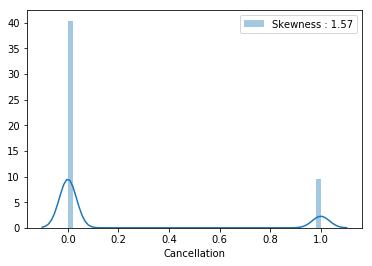

In [68]:
p = sns.distplot(train_claim_df['Cancellation'])
p = p.legend(['Skewness : {:.2f}'.format(train_claim_df['Cancellation'].skew())],loc='best')

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


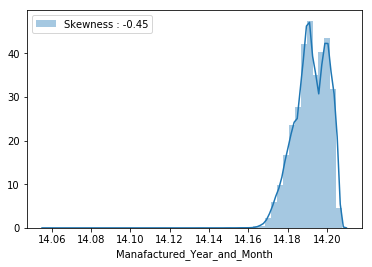

In [101]:
p = sns.distplot(train_claim_df['Manafactured_Year_and_Month'])
p = p.legend(['Skewness : {:.2f}'.format(train_claim_df['Manafactured_Year_and_Month'].skew())],loc='best')

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


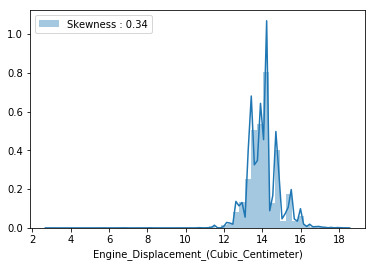

In [102]:
p = sns.distplot(train_claim_df['Engine_Displacement_(Cubic_Centimeter)'])
p = p.legend(['Skewness : {:.2f}'.format(train_claim_df['Engine_Displacement_(Cubic_Centimeter)'].skew())],loc='best')

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


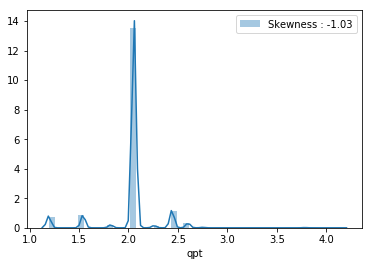

In [103]:
p = sns.distplot(train_claim_df['qpt'])
p = p.legend(['Skewness : {:.2f}'.format(train_claim_df['qpt'].skew())],loc='best')

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


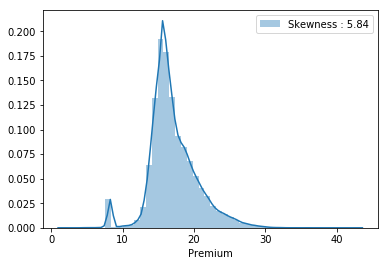

In [104]:
p = sns.distplot(train_claim_df['Premium'])
p = p.legend(['Skewness : {:.2f}'.format(train_claim_df['Next_Premium'].skew())],loc='best')

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


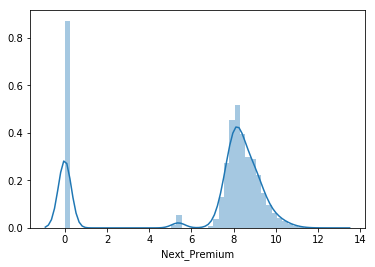

In [105]:
p = sns.distplot(np.log1p(train_claim_df['Next_Premium']))

C:\Users\Asus\Anaconda3\envs\AI\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


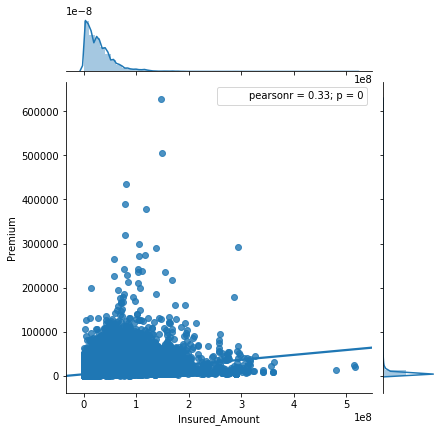

In [74]:
g = sns.jointplot(x = train_claim_df['Insured_Amount'], y = train_claim_df['Premium'],kind="reg")

In [79]:
train_claim_df[(train_claim_df['Next_Premium'] == 0) & (train_claim_df['Premium'] > 0)].index.values

array([     8,     21,     30, ..., 210751, 210752, 210758], dtype=int64)

In [80]:
train_only_renew = train_claim_df.drop(train_claim_df[(train_claim_df['Next_Premium'] == 0) & (train_claim_df['Premium'] > 0)].index.values)

In [106]:
# train_df.to_csv('../dataset/train_df_0910.csv', sep=',', index=None)
# test_df.to_csv('../dataset/test_df_0910.csv', sep=',', index=None)
train_claim_df.to_csv('../dataset/train_claim_df_0912.csv', sep=',', index=None)
test_claim_df.to_csv('../dataset/test_claim_df_0912.csv', sep=',', index=None)
#train_only_renew.to_csv('../dataset/train_only_renew_new.csv', sep=',', index=None)